# Pneumonia Detection 
##What is Pneumonia?
Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli.Symptoms typically include some combination of productive or dry cough, chest pain, fever and difficulty breathing. The severity of the condition is variable. Pneumonia is usually caused by infection with viruses or bacteria and less commonly by other microorganisms, certain medications or conditions such as autoimmune diseases.Risk factors include cystic fibrosis, chronic obstructive pulmonary disease (COPD), asthma, diabetes, heart failure, a history of smoking, a poor ability to cough such as following a stroke and a weak immune system. Diagnosis is often based on symptoms and physical examination. Chest X-ray, blood tests, and culture of the sputum may help confirm the diagnosis.The disease may be classified by where it was acquired, such as community- or hospital-acquired or healthcare-associated pneumonia.
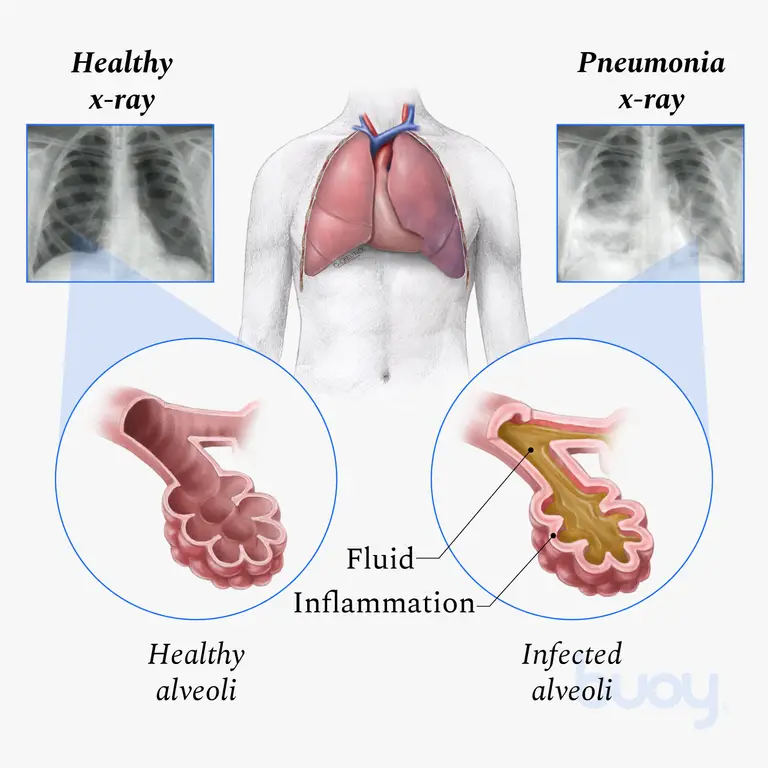




## Importing the necessary libraries

In [28]:
import numpy as np
import pandas as pd 
import random as rn
import tensorflow as tf
import tensorflow.random as tfr
import tensorflow.keras as keras
from keras import layers
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,Dropout,Flatten,Dense,Activation,BatchNormalization,add
from tensorflow.keras.models  import Model,Sequential,load_model
from tensorflow.keras.utils import plot_model
from keras.applications.vgg19 import VGG19,preprocess_input
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import  Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import glob
from skimage import color, exposure
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
import os
import cv2
import pickle

# Setting the same seed for repeatability

seed = 0

np.random.seed(seed) 
rn.seed(seed)
tfr.set_seed(seed)

# Display graphs in a Jupyter
%matplotlib inline

print("Imported")

Imported


## connect to Google drive

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


##Description of the Pneumonia Dataset
The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal). Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care. For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

###Loading the Dataset

In [5]:
train_folder = '/content/drive/MyDrive/project/chest_xray/train/'
val_folder = '/content/drive/MyDrive/project/chest_xray/val/'
test_folder = '/content/drive/MyDrive/project/chest_xray/test/'

## change size of image size

In [5]:
img_size = 200

In [6]:
#read data

def read_data(data_paths):
    for data_path in data_paths:
        labels = ['PNEUMONIA', 'NORMAL']
        images = []
        y = []
        for label in labels:
            curr_path = data_path + label
            for img in os.listdir(curr_path):
                if ('DS' not in img):
                    image_path = os.path.join(curr_path, img)
                    image =  cv2.resize(cv2.imread(image_path), (img_size, img_size))
                    if image is not None:
                        images.append([image, label])
                
    images = np.asarray(images)
    return images

In [7]:
train = read_data([train_folder])
test = read_data([test_folder])
val=read_data([val_folder])

<ipython-input-6-737ce99fc3b6>:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  images = np.asarray(images)


### merged train and validation data as very few images are there in valadation folder

In [8]:
train_1=np.vstack([train,val])
train_1.shape

(5232, 2)

In [9]:
train_df = pd.DataFrame(train_1, columns=['image', 'label'])
test_df = pd.DataFrame(test, columns = ['image', 'label'])

In [10]:
train_df['label'].head()

0    PNEUMONIA
1    PNEUMONIA
2    PNEUMONIA
3    PNEUMONIA
4    PNEUMONIA
Name: label, dtype: object

## Exploratory Data Analysis and Visualization

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


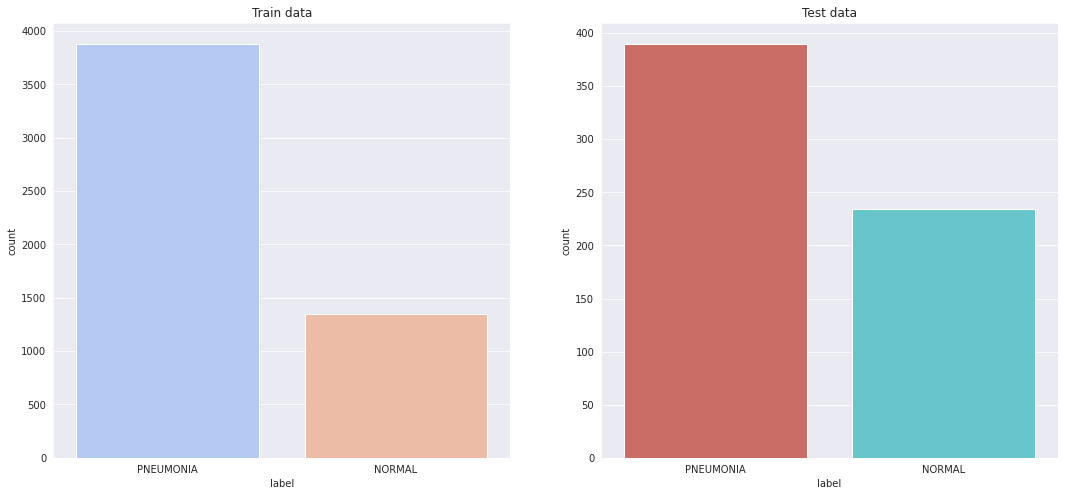

In [10]:
plt.figure(figsize=(18, 8))
sns.set_style("darkgrid")

plt.subplot(1,2,1)
sns.countplot(train_df['label'], palette = 'coolwarm')
plt.title('Train data')

plt.subplot(1,2,2)
sns.countplot(test_df['label'], palette = "hls")
plt.title('Test data')

plt.show()

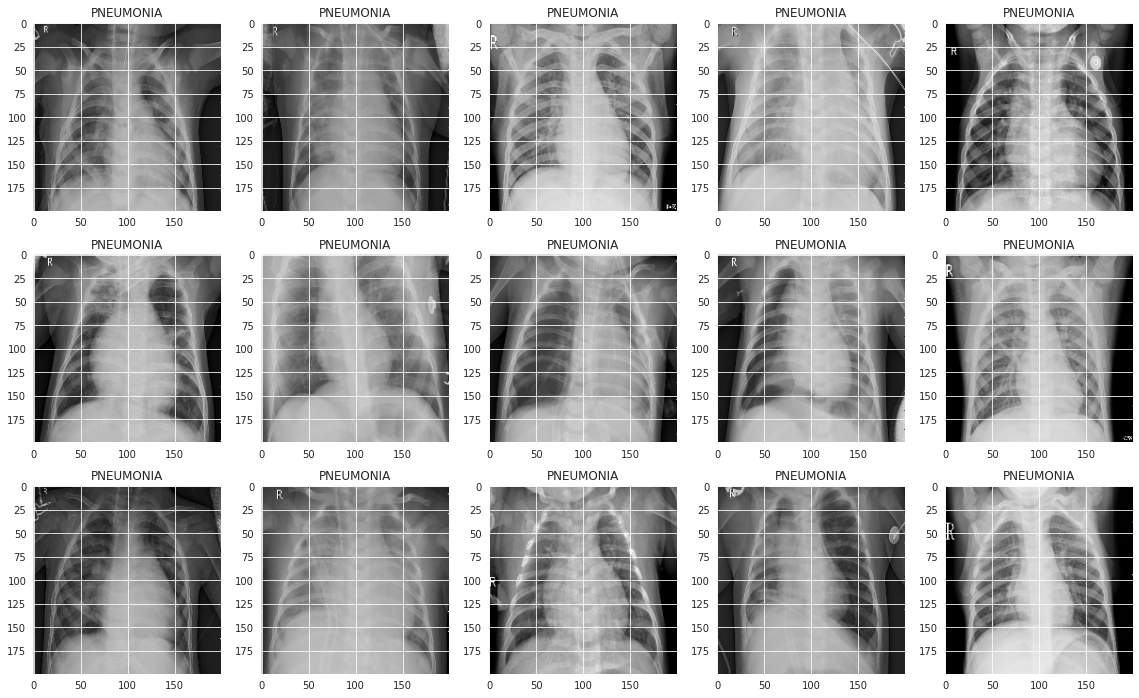

In [11]:
def Show_example_image():
    fig = plt.figure(figsize = (16, 16))
    for idx in range(15):
        plt.subplot(5, 5, idx+1)
        plt.imshow(train_df.iloc[idx]['image'])
        plt.title("{}".format(train_df.iloc[idx]['label']))
        
    plt.tight_layout()
    
Show_example_image()

##Data preprocessing

### assigning labels 1 for pneumonia and o for normal

In [11]:
def lung_condition(label):
    if label == 'NORMAL':
        return 0
    else:
        return 1

In [12]:
#Function for dividing data into arrays X and y
def splitdata(data):
    X = []
    y = []
    for i, (val, label) in enumerate(data):
        X.append(val)
        y.append(lung_condition(label))
    return np.array(X), np.array(y)

In [13]:
#splitting the data
np.random.shuffle(train_1)
np.random.shuffle(test)
X_train, y_train = splitdata(train_1)
X_test, y_test = splitdata(test)

In [13]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((5232, 200, 200, 3), (5232,), (624, 200, 200, 3), (624,))

In [14]:
#Grayscale conversion, normalization and table reshaping function for MLP
def preprocesing_to_gray(data):
    data1 = color.rgb2gray(data).reshape(-1, img_size , img_size,1).astype('float32')
    
    # Data Normalization [0, 1]
    data1 /= 255
    
    return data1   

### changing the images to gray scale 

In [15]:
X_train = preprocesing_to_gray(X_train)
X_test = preprocesing_to_gray(X_test)
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((5232, 200, 200, 1), (5232,), (624, 200, 200, 1), (624,))

In [16]:
num_pixels = X_train.shape[1] 

# one-hot encoding for target column
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

num_classes = y_train.shape[1]

### function to draw accuracy and loss curvesold text**

In [18]:
def draw_learning_curve(history, keys=['accuracy', 'loss']):
    plt.figure(figsize=(20,8))
    for i, key in enumerate(keys):
        plt.subplot(1, 2, i + 1)
        sns.lineplot(x = history.epoch, y = history.history[key])
        sns.lineplot(x = history.epoch, y = history.history['val_' + key])
        plt.title('Learning Curve')
        plt.ylabel(key.title())
        plt.xlabel('Epoch')
#         plt.ylim(ylim)
        plt.legend(['train', 'test'], loc='best')
    plt.show()

##Data Augmentation
In order to avoid overfitting problem, we need to expand artificially our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations. Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more. By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

In [18]:
datagen = ImageDataGenerator(
        featurewise_center = False,
        samplewise_center = False,
        featurewise_std_normalization = False, 
        samplewise_std_normalization = False,
        zca_whitening = False,
        horizontal_flip = False,
        vertical_flip = False,
        rotation_range = 10,  
        zoom_range = 0.1, 
        width_shift_range = 0.1, 
        height_shift_range = 0.1)

In [19]:
datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train, batch_size = 32)

###Training the custom Model

In [20]:
model_cnn1=Sequential()
model_cnn1.add(layers.Conv2D(16,(3,3),padding='same',activation='relu',input_shape=(X_train.shape[1], X_train.shape[2], 1)))
model_cnn1.add(layers.Conv2D(16,(3,3),padding='same',activation='relu'))
model_cnn1.add(layers.BatchNormalization())
model_cnn1.add(layers.MaxPool2D(pool_size=(2, 2)))
model_cnn1.add(layers.Dropout(0.2))

model_cnn1.add(layers.Conv2D(32,(3,3),padding='same',activation='relu'))
model_cnn1.add(layers.Conv2D(32,(3,3),padding='same',activation='relu'))
model_cnn1.add(layers.BatchNormalization())
model_cnn1.add(layers.MaxPool2D(pool_size=(2, 2)))
model_cnn1.add(layers.Dropout(0.2))

model_cnn1.add(layers.Conv2D(64,(3,3),padding='same',activation='relu'))
model_cnn1.add(layers.Conv2D(64,(3,3),padding='same',activation='relu'))
model_cnn1.add(layers.BatchNormalization())
model_cnn1.add(layers.MaxPool2D(pool_size=(2, 2)))
model_cnn1.add(layers.Dropout(0.2))

model_cnn1.add(layers.Conv2D(128,(3,3),padding='same',activation='relu'))
model_cnn1.add(layers.Conv2D(128,(3,3),padding='same',activation='relu'))
model_cnn1.add(layers.BatchNormalization())
model_cnn1.add(layers.MaxPool2D(pool_size=(2, 2)))
model_cnn1.add(layers.Dropout(0.2))

model_cnn1.add(layers.Conv2D(256,(3,3),padding='same',activation='relu'))
model_cnn1.add(layers.Conv2D(256,(3,3),padding='same',activation='relu'))
model_cnn1.add(layers.BatchNormalization())
model_cnn1.add(layers.MaxPool2D(pool_size=(2, 2)))
model_cnn1.add(layers.Dropout(0.2))

model_cnn1.add(layers.Flatten())

model_cnn1.add(layers.Dense(1024,activation='relu'))
model_cnn1.add(layers.BatchNormalization())
model_cnn1.add(layers.Dropout(0.5))

model_cnn1.add(layers.Dense(512,activation='relu'))
model_cnn1.add(layers.BatchNormalization())
model_cnn1.add(layers.Dropout(0.4))

model_cnn1.add(layers.Dense(256,activation='relu'))
model_cnn1.add(layers.BatchNormalization())
model_cnn1.add(layers.Dropout(0.3))

model_cnn1.add(layers.Dense(64,activation='relu'))
model_cnn1.add(layers.BatchNormalization())
model_cnn1.add(layers.Dropout(0.2))

model_cnn1.add(layers.Dense(num_classes,activation='softmax'))
model_cnn1.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer='adam')

### custom model architecture

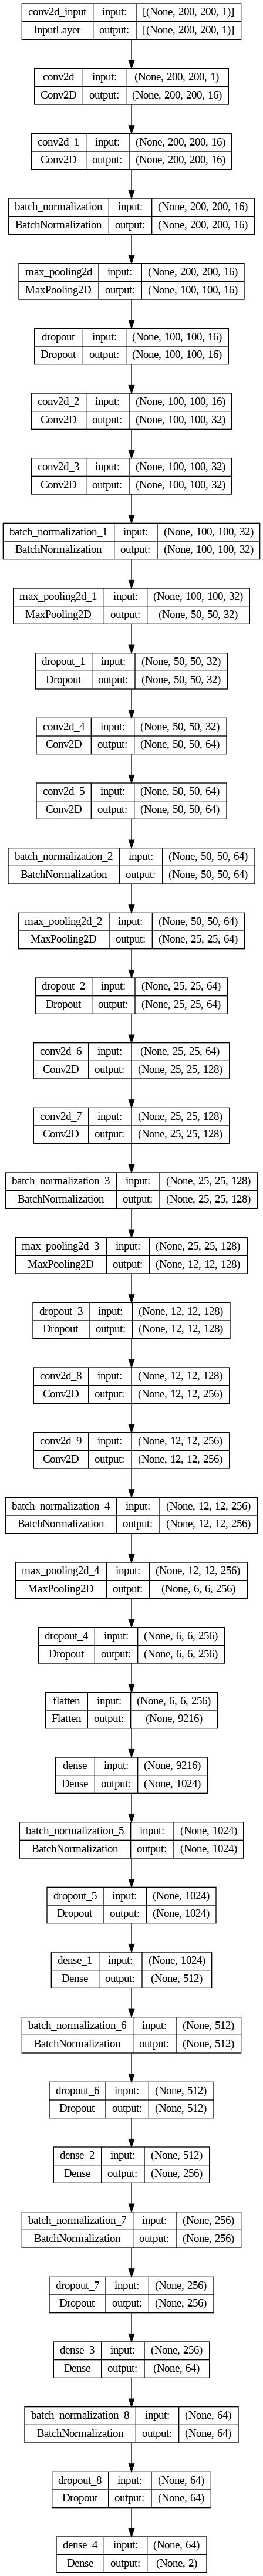

In [22]:
tf.keras.utils.plot_model(
    model_cnn1, to_file='model_cnn1.png', show_shapes=True,
    show_layer_names=True,
)

### Setting callbacks

In [21]:
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
callbacks = [ 
    EarlyStopping(monitor = 'loss', patience = 8), 
    ReduceLROnPlateau(monitor = 'loss', patience = 3), 
    ModelCheckpoint('model_Pneumonia_final.hdf5', monitor='loss' , save_best_only=True) # saving the best model
    ]

### Running the model on train and test datasets

In [22]:
learning_history_1 = model_cnn1.fit_generator((train_gen), 
                               epochs = 100, 
                               steps_per_epoch = X_train.shape[0] // 32,
                               validation_data = (X_test, y_test),
                               callbacks = callbacks,
                        )

<ipython-input-22-89c4a28ed2a9>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  learning_history_1 = model_cnn1.fit_generator((train_gen),


Epoch 1/100
163/163 [==============================] - 33s 132ms/step - loss: 0.5882 - accuracy: 0.7338 - val_loss: 4.1160 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 2/100
163/163 [==============================] - 18s 111ms/step - loss: 0.2956 - accuracy: 0.8838 - val_loss: 4.0931 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 3/100
163/163 [==============================] - 18s 111ms/step - loss: 0.2586 - accuracy: 0.9010 - val_loss: 2.7628 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/100
163/163 [==============================] - 19s 113ms/step - loss: 0.2159 - accuracy: 0.9171 - val_loss: 2.6365 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 5/100
163/163 [==============================] - 19s 114ms/step - loss: 0.1794 - accuracy: 0.9329 - val_loss: 2.1300 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 6/100
163/163 [==============================] - 18s 113ms/step - loss: 0.1656 - accuracy: 0.9398 - val_loss: 2.5930 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 7/100
163/163 [=========================

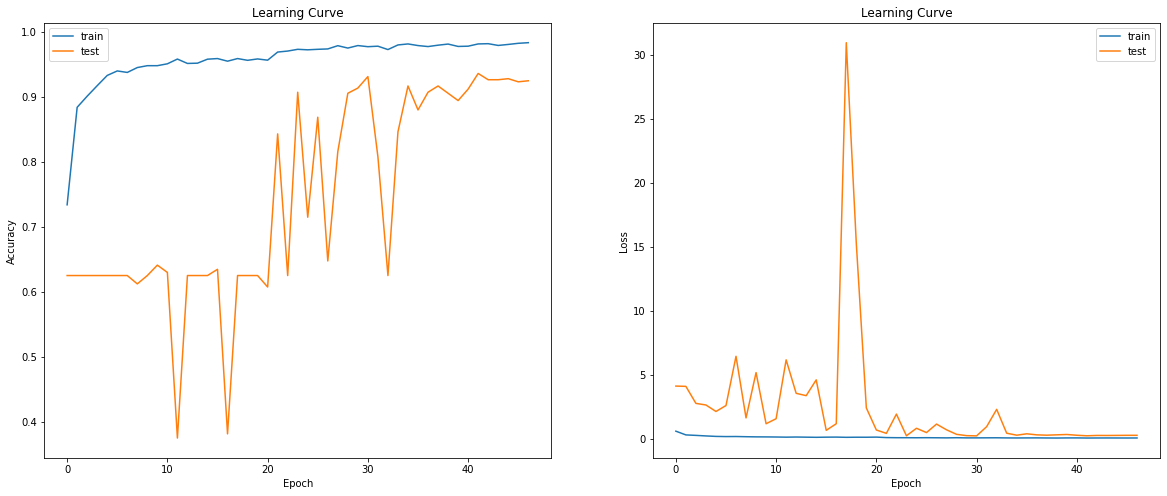

In [23]:
draw_learning_curve(learning_history_1 )

In [26]:
predictions = model_cnn1.predict(X_test)
predictions =np.argmax(predictions, axis = 1)

20/20 [==============================] - 1s 21ms/step


In [27]:
y_pre_test = np.argmax(y_test, axis = 1)

In [28]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_pre_test, predictions, target_names = ['Pneumonia (Class 1)','Normal (Class 0)']))

                     precision    recall  f1-score   support

Pneumonia (Class 1)       0.98      0.81      0.89       234
   Normal (Class 0)       0.90      0.99      0.94       390

           accuracy                           0.92       624
          macro avg       0.94      0.90      0.92       624
       weighted avg       0.93      0.92      0.92       624



In [29]:
cm = confusion_matrix(y_pre_test,predictions)
cm

array([[190,  44],
       [  3, 387]])

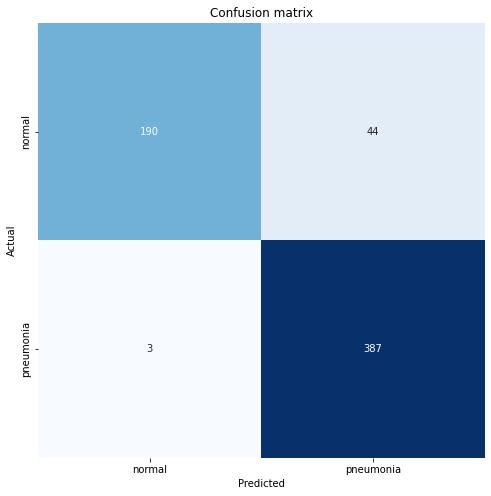

In [32]:
classnames = ['normal','pneumonia']
plt.figure(figsize=(8,8))
plt.title('Confusion matrix')
sns.heatmap(cm, cbar=False, xticklabels=classnames, yticklabels=classnames, fmt='d', annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [30]:
correct = np.nonzero(predictions == y_pre_test)[0]
incorrect = np.nonzero(predictions != y_pre_test)[0]

In [31]:
incorrect

array([ 24,  51,  59,  64,  77,  79, 108, 127, 129, 168, 171, 199, 214,
       237, 275, 289, 293, 298, 312, 315, 317, 323, 348, 361, 362, 389,
       405, 429, 455, 457, 469, 491, 496, 509, 514, 531, 543, 556, 559,
       582, 583, 587, 601, 603, 611, 619, 621])

#Tensorflow(Keras) supports transfer learning with a variety of models with  pre-trained weights like ChestXNet and ImageNet. 
##Some of them are:

###1.VGG16, VGG19
###2.Densenet121
###3.EfficientNet
###4.ResNet50, ResNet101, Resnet152v2 etc
###5.InceptionResNetv2
###6.Xception and the list go on

## Iam just running the best model architecture after experimenting above all model architectures

In [2]:
img_size=224

In [6]:
def read_data(data_paths):
    for data_path in data_paths:
        labels = ['PNEUMONIA', 'NORMAL']
        images = []
        y = []
        for label in labels:
            curr_path = data_path + label
            for img in os.listdir(curr_path):
                if ('DS' not in img):
                    image_path = os.path.join(curr_path, img)
                    image =  cv2.resize(cv2.imread(image_path), (img_size, img_size))
                    if image is not None:
                        images.append([image, label])
                
    images = np.asarray(images)
    return images

In [7]:
train = read_data([train_folder])
test = read_data([test_folder])
val=read_data([val_folder])

<ipython-input-6-5b622a87ddd1>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  images = np.asarray(images)


In [8]:
train_1=np.vstack([train,val])
train_1.shape

(5232, 2)

In [9]:
def lung_condition(label):
    if label == 'NORMAL':
        return 0
    else:
        return 1
#Function for dividing data into arrays X and y
def splitdata(data):
    X = []
    y = []
    for i, (val, label) in enumerate(data):
        X.append(val)
        y.append(lung_condition(label))
    return np.array(X), np.array(y)

In [10]:
#splitting the data
np.random.shuffle(train_1)
np.random.shuffle(test)
X_train, y_train = splitdata(train_1)
X_test, y_test = splitdata(test)
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((5232, 224, 224, 3), (5232,), (624, 224, 224, 3), (624,))

In [11]:
num_pixels = X_train.shape[1] 

# one-hot encoding for target column
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

num_classes = y_train.shape[1]

In [12]:
datagen = ImageDataGenerator(
        featurewise_center = False,
        samplewise_center = False,
        featurewise_std_normalization = False, 
        samplewise_std_normalization = False,
        zca_whitening = False,
        horizontal_flip = False,
        vertical_flip = False,
        rotation_range = 10,  
        zoom_range = 0.1, 
        width_shift_range = 0.1, 
        height_shift_range = 0.1)

datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train, batch_size = 32)

### VGG19 with ChestXNet weights for transfer learning

In [13]:
# loading the VGG19 model with ChestXNet weights without the FC layers
path_to_weights = '/content/drive/MyDrive/project/chest_xray/brucechou1983_CheXNet_Keras_0.3.0_weights.h5'
vgg = VGG19(include_top=False,input_shape=(224,224,3))
vgg.load_weights(path_to_weights, by_name=True)
for layer in vgg.layers:
    layer.trainable = False #making all the layers non-trainable
    
x = Flatten()(vgg.output) #flattening out the last layer
predictions = Dense(2,activation='softmax')(x) #Dense layer to predict wether their is pneumonia or not
model = Model(inputs=vgg.input, outputs=predictions)
model.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [14]:
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer='adam')

In [15]:
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
callbacks = [ 
    EarlyStopping(monitor = 'loss', patience = 8), 
    ReduceLROnPlateau(monitor = 'loss', patience = 3), 
    ModelCheckpoint('model_Pneumonia_VGG19_chestXNet.hdf5', monitor='loss' , save_best_only=True) # saving the best model
    ]

In [16]:
learning_history_1 = model.fit_generator((train_gen), 
                               epochs = 100, 
                               steps_per_epoch = X_train.shape[0] // 32,
                               validation_data = (X_test, y_test),
                               callbacks = callbacks,
                        )

<ipython-input-16-10f4380945a3>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  learning_history_1 = model.fit_generator((train_gen),


Epoch 1/100
163/163 [==============================] - 75s 391ms/step - loss: 2.1512 - accuracy: 0.9308 - val_loss: 3.4042 - val_accuracy: 0.9247 - lr: 0.0010
Epoch 2/100
163/163 [==============================] - 61s 373ms/step - loss: 1.4741 - accuracy: 0.9575 - val_loss: 9.9843 - val_accuracy: 0.8574 - lr: 0.0010
Epoch 3/100
163/163 [==============================] - 61s 375ms/step - loss: 1.0641 - accuracy: 0.9675 - val_loss: 10.9498 - val_accuracy: 0.8429 - lr: 0.0010
Epoch 4/100
163/163 [==============================] - 62s 381ms/step - loss: 1.3723 - accuracy: 0.9612 - val_loss: 16.4081 - val_accuracy: 0.8221 - lr: 0.0010
Epoch 5/100
163/163 [==============================] - 61s 374ms/step - loss: 1.4244 - accuracy: 0.9706 - val_loss: 10.1048 - val_accuracy: 0.8830 - lr: 0.0010
Epoch 6/100
163/163 [==============================] - 61s 374ms/step - loss: 0.9638 - accuracy: 0.9769 - val_loss: 15.9732 - val_accuracy: 0.8301 - lr: 0.0010
Epoch 7/100
163/163 [=====================

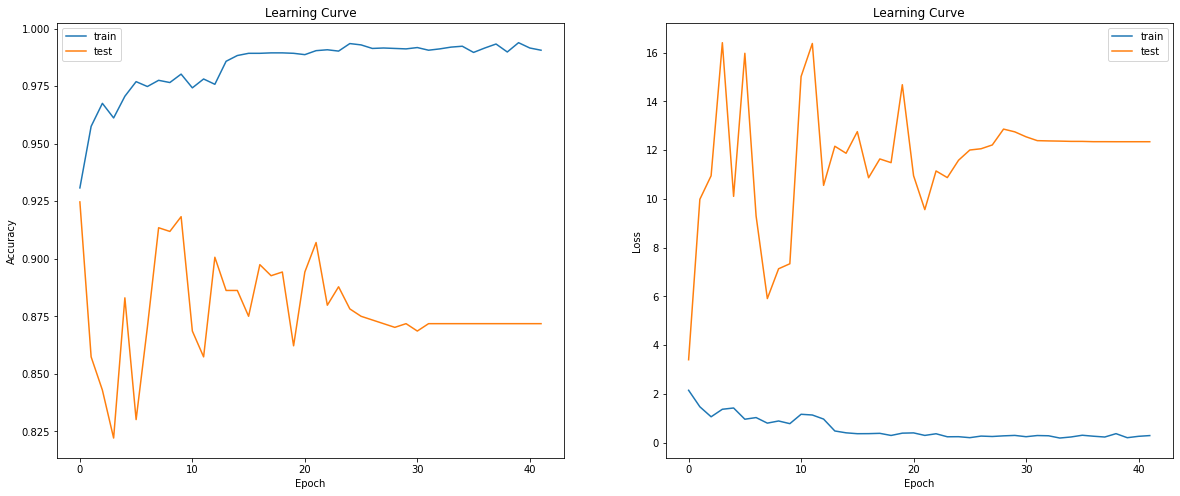

In [19]:
draw_learning_curve(learning_history_1 )

### VGG19 with imagenet weights for transfer learning

In [20]:
# loading the VGG19 model with imagenet weights without the FC layers
vgg19 = VGG19(weights='imagenet',include_top=False,input_shape=(224,224,3))
for layer in vgg19.layers:
    layer.trainable = False #making all the layers non-trainable
    
x = Flatten()(vgg19.output) #flattening out the last layer
predictions = Dense(2,activation='softmax')(x) #Dense layer to predict wether their is pneumonia or not
model = Model(inputs=vgg19.input, outputs=predictions)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [21]:
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer='adam')

In [22]:
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
callbacks = [ 
    EarlyStopping(monitor = 'val_accuracy', patience = 8), 
    ReduceLROnPlateau(monitor = 'val_accuracy', patience = 3), 
    ModelCheckpoint('model_Pneumonia_VGG19.hdf5', monitor='val_accuracy' , save_best_only=True) # saving the best model
    ]

In [23]:
learning_history_1 = model.fit_generator((train_gen), 
                               epochs = 100, 
                               steps_per_epoch = X_train.shape[0] // 32,
                               validation_data = (X_test, y_test),
                               callbacks = callbacks,
                        )

<ipython-input-23-10f4380945a3>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  learning_history_1 = model.fit_generator((train_gen),


Epoch 1/100
163/163 [==============================] - 61s 373ms/step - loss: 1.8093 - accuracy: 0.9350 - val_loss: 5.2529 - val_accuracy: 0.8766 - lr: 0.0010
Epoch 2/100
163/163 [==============================] - 61s 374ms/step - loss: 1.2192 - accuracy: 0.9585 - val_loss: 3.5677 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 3/100
163/163 [==============================] - 61s 372ms/step - loss: 1.2791 - accuracy: 0.9610 - val_loss: 11.6302 - val_accuracy: 0.8381 - lr: 0.0010
Epoch 4/100
163/163 [==============================] - 61s 372ms/step - loss: 0.9675 - accuracy: 0.9685 - val_loss: 8.3033 - val_accuracy: 0.8830 - lr: 0.0010
Epoch 5/100
163/163 [==============================] - 62s 380ms/step - loss: 1.2680 - accuracy: 0.9710 - val_loss: 5.9483 - val_accuracy: 0.9279 - lr: 0.0010
Epoch 6/100
163/163 [==============================] - 61s 373ms/step - loss: 0.9968 - accuracy: 0.9719 - val_loss: 13.2732 - val_accuracy: 0.8654 - lr: 0.0010
Epoch 7/100
163/163 [=======================

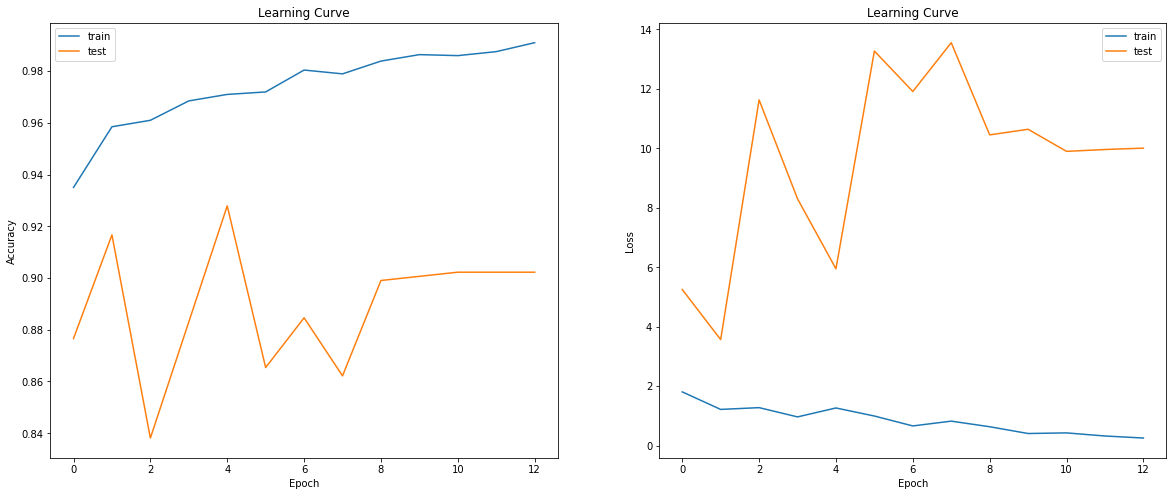

In [24]:
draw_learning_curve(learning_history_1 )

In [36]:
model.load_weights('/content/model_Pneumonia_VGG19.hdf5')


In [37]:
predictions = model.predict(X_test)
predictions =np.argmax(predictions, axis = 1)

20/20 [==============================] - 3s 172ms/step


In [38]:
y_pre_test = np.argmax(y_test, axis = 1)

In [40]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_pre_test, predictions, target_names = ['Normal (Class 0)','Pneumonia (Class 1)']))

                     precision    recall  f1-score   support

   Normal (Class 0)       0.93      0.88      0.90       234
Pneumonia (Class 1)       0.93      0.96      0.94       390

           accuracy                           0.93       624
          macro avg       0.93      0.92      0.92       624
       weighted avg       0.93      0.93      0.93       624



In [41]:
cm = confusion_matrix(y_pre_test,predictions)
cm

array([[205,  29],
       [ 16, 374]])

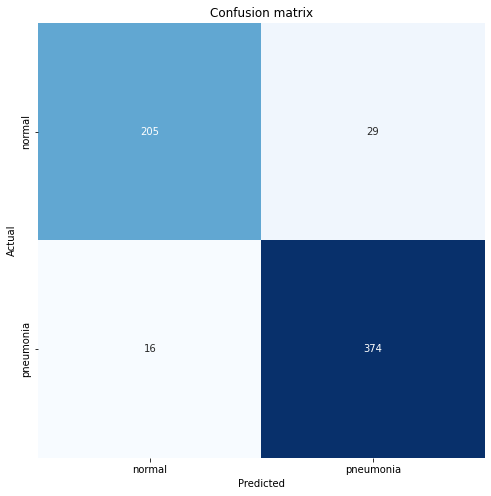

In [44]:
classnames = ['normal','pneumonia']
plt.figure(figsize=(8,8))
plt.title('Confusion matrix')
sns.heatmap(cm, cbar=False, xticklabels=classnames, yticklabels=classnames, fmt='d', annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [42]:
correct = np.nonzero(predictions == y_pre_test)[0]
incorrect = np.nonzero(predictions != y_pre_test)[0]

In [43]:
incorrect

array([ 24,  30,  43,  50,  64,  95, 108, 138, 142, 150, 168, 171, 209,
       237, 238, 275, 280, 298, 303, 309, 316, 323, 342, 348, 359, 389,
       405, 429, 433, 457, 463, 479, 509, 513, 515, 526, 542, 543, 556,
       559, 582, 587, 601, 611, 621])

By using transfer learning technique we can easly reach the maximum accuracy quickly and transfer learning is good to use with imagenet weights.